# 4.4 Low-Dimensional Embedding For Dirichlet-Multinomial Data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from scipy.special import psi
import random
from sklearn.model_selection import train_test_split

In [2]:
EPS = torch.finfo(torch.float64).eps

In [3]:
def criterion_beta_liouville_multinomial(alpha_i, alpha, beta, target):
    target = torch.clamp(target, min=EPS)
    alpha = torch.clamp(alpha, min=EPS)
    beta = torch.clamp(beta, min=EPS)
    alpha_i = torch.clamp(alpha_i, min=EPS)
    
    alpha_i_prime = alpha_i + target[:, :-1]
    alpha_prime = alpha + torch.sum(target[:, :-1], dim=1)
    beta_prime = beta + target[:, -1]
    
    return -(torch.lgamma(torch.sum(target, dim=1) + 1) - torch.sum(torch.lgamma(target + 1), dim=1)
            + torch.lgamma(torch.sum(alpha_i, dim=1)) - torch.lgamma(torch.sum(alpha_i_prime, dim=1))
            + torch.lgamma(alpha + beta) - torch.lgamma(alpha_prime + beta_prime)
            + torch.lgamma(alpha_prime) - torch.lgamma(alpha)
            + torch.lgamma(beta_prime) - torch.lgamma(beta)
            + torch.sum(torch.lgamma(alpha_i_prime), dim=1) - torch.sum(torch.lgamma(alpha_i), dim=1)).mean()

In [4]:
torch.use_deterministic_algorithms(True)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [5]:
num_dim = 100
num_clusters = 10
num_samples_per_cluster = 1000

In [6]:
alpha = (0.1, ) * num_dim

In [7]:
X = np.zeros((num_clusters * num_samples_per_cluster, num_dim))
y = np.zeros((num_clusters * num_samples_per_cluster, ))

In [8]:
for i in range(num_clusters):
    n = math.floor(np.random.uniform(50, 100, 1))
    p = np.random.dirichlet(alpha, 1)[0]
    X[i * num_samples_per_cluster : (i + 1) * num_samples_per_cluster, :] = np.random.multinomial(n, p, size=num_samples_per_cluster)
    y[i * num_samples_per_cluster : (i + 1) * num_samples_per_cluster] = i

In [9]:
X_tensor = torch.tensor(X, dtype=torch.float64)
y_tensor = torch.tensor(y, dtype=torch.int64)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [11]:
dataset_train = torch.utils.data.TensorDataset(X_train, Y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, Y_test)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [12]:
class IL(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        eps = 1e-6
        return torch.where(x < 0, (1 / (1 - x)) + eps, x + 1 + eps)

In [13]:
class EL(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.nn.functional.elu(x) + 1

In [14]:
def plot_latent(autoencoder, data, label):
    encoded = model.encoder(data).detach().numpy()
    plt.scatter(encoded[:, 0], encoded[:, 1], c=label.detach().numpy())
    plt.colorbar()

In [15]:
batch_size = 100
n_epochs = 100

In [16]:
class AutoEncoderBaseline(nn.Module):
    def __init__(self, num_input=100, num_bottleneck=2):
        super(AutoEncoderBaseline, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 100, dtype=torch.float64),
            nn.ReLU(True),
            nn.Linear(100, 64, dtype=torch.float64),
            nn.ReLU(True), nn.Linear(64, 12, dtype=torch.float64), nn.ReLU(True), nn.Linear(12, num_bottleneck, dtype=torch.float64))
        self.decoder = nn.Sequential(
            nn.Linear(num_bottleneck, 12, dtype=torch.float64),
            nn.ReLU(True),
            nn.Linear(12, 64, dtype=torch.float64),
            nn.ReLU(True),
            nn.Linear(64, 100, dtype=torch.float64),
            nn.ReLU(True), nn.Linear(100, num_input, dtype=torch.float64))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
model = AutoEncoderBaseline()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
for epoch in range(1, n_epochs + 1):
    for i in range(0, 10000, batch_size):
        X_batch = X_tensor[i: i+batch_size]
        output = model(X_batch)
        loss = criterion(output, X_batch)
        if i == 0:
            # print(output)
            # print(X_batch)
            print(f"Epoch {epoch}: loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 1: loss: 5.261938489903658
Epoch 2: loss: 4.653479101841764
Epoch 3: loss: 5.119325222963981
Epoch 4: loss: 4.039541509625288
Epoch 5: loss: 3.888424983888145
Epoch 6: loss: 3.9219288893586155
Epoch 7: loss: 4.350337413435339
Epoch 8: loss: 4.575652511998317
Epoch 9: loss: 4.394770935504789
Epoch 10: loss: 4.565332559195037
Epoch 11: loss: 4.410604166635317
Epoch 12: loss: 4.6939242501512
Epoch 13: loss: 4.224710318121977
Epoch 14: loss: 4.089109601929649
Epoch 15: loss: 3.997129200887712
Epoch 16: loss: 3.972904733226269
Epoch 17: loss: 3.973999153900562
Epoch 18: loss: 3.9471722127485425
Epoch 19: loss: 3.9731602791222214
Epoch 20: loss: 3.858465545898571
Epoch 21: loss: 3.99376567990183
Epoch 22: loss: 4.020276321114854
Epoch 23: loss: 4.3036310484037585
Epoch 24: loss: 3.966899564683519
Epoch 25: loss: 4.2423187768121755
Epoch 26: loss: 4.052342061374541
Epoch 27: loss: 4.039809561341324
Epoch 28: loss: 4.393112133719027
Epoch 29: loss: 4.817605034906018
Epoch 30: loss: 3.989

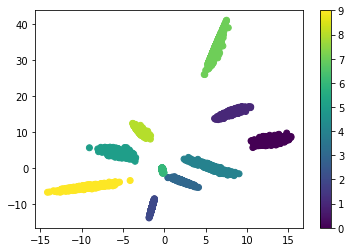

In [19]:
plot_latent(model, X_train, Y_train)

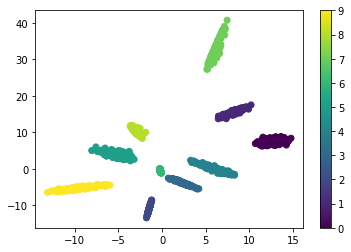

In [20]:
plot_latent(model, X_test, Y_test)

In [21]:
class AutoEncoder(nn.Module):
    def __init__(self, num_input=100, num_bottleneck=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 64, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(64, 12, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(12, num_bottleneck, dtype=torch.float64)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(num_bottleneck, 12, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(12, 64, dtype=torch.float64),
            nn.Tanh()
        )
        
        self.GeneralizedDirichletMultinomialAlpha_i = nn.Sequential(
        nn.Linear(64, num_input - 1, dtype=torch.float64),
        EL()
        )
        
        self.GeneralizedDirichletMultinomialAlpha = nn.Sequential(
        nn.Linear(64, 1, dtype=torch.float64),
        EL()
        )
        
        self.GeneralizedDirichletMultinomialBeta = nn.Sequential(
        nn.Linear(64, 1, dtype=torch.float64),
        EL()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        alpha_i = self.GeneralizedDirichletMultinomialAlpha_i(decoded)
        alpha = self.GeneralizedDirichletMultinomialAlpha(decoded)
        beta = self.GeneralizedDirichletMultinomialBeta(decoded)
        return alpha_i, alpha, beta

In [22]:
num_bottleneck = 2
model = AutoEncoder(num_dim, num_bottleneck)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [23]:
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=12, bias=True)
    (3): Tanh()
    (4): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
  )
  (GeneralizedDirichletMultinomialAlpha_i): Sequential(
    (0): Linear(in_features=64, out_features=99, bias=True)
    (1): EL()
  )
  (GeneralizedDirichletMultinomialAlpha): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): EL()
  )
  (GeneralizedDirichletMultinomialBeta): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): EL()
  )
)


In [24]:
for epoch in range(1, n_epochs + 1):
    for i in range(0, 10000, batch_size):
        X_batch = X_tensor[i: i+batch_size]
        
        alpha_i, alpha, beta = model(X_batch)
        loss = criterion_beta_liouville_multinomial(alpha_i, alpha, beta, X_batch)
        if i == 0:
            print(f"Epoch {epoch}: loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 1: loss: 121.05155697578846
Epoch 2: loss: 117.04534632425722
Epoch 3: loss: 113.45890037553275
Epoch 4: loss: 109.19811282185894
Epoch 5: loss: 104.35308779894117
Epoch 6: loss: 99.44140975293878
Epoch 7: loss: 94.97465155804849
Epoch 8: loss: 91.27416199751907
Epoch 9: loss: 88.37082847239601
Epoch 10: loss: 86.1223775229512
Epoch 11: loss: 84.40010572661315
Epoch 12: loss: 83.09569613160957
Epoch 13: loss: 82.09802676739726
Epoch 14: loss: 81.32893634092933
Epoch 15: loss: 80.72522501154525
Epoch 16: loss: 80.24119869549337
Epoch 17: loss: 79.84376072914307
Epoch 18: loss: 79.51047379740882
Epoch 19: loss: 79.22626582197438
Epoch 20: loss: 78.97992156655022
Epoch 21: loss: 78.75764817171327
Epoch 22: loss: 78.54699011562735
Epoch 23: loss: 78.34335270532665
Epoch 24: loss: 78.15411185355237
Epoch 25: loss: 77.96937248346077
Epoch 26: loss: 77.794645939302
Epoch 27: loss: 77.62455992867277
Epoch 28: loss: 77.46139582469782
Epoch 29: loss: 77.30576894107267
Epoch 30: loss: 77.15

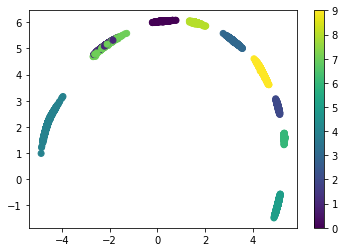

In [25]:
plot_latent(model, X_train, Y_train)

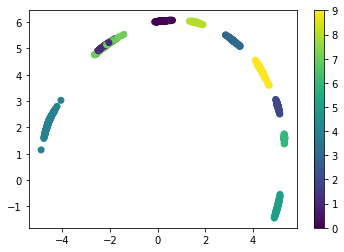

In [26]:
plot_latent(model, X_test, Y_test)